In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow import keras
from helper_functions import create_tf_data_datasets
from helper_functions import plot_triplet_roc_curve_new
from helper_functions import plot_triplet_training

In [ ]:
#new_model = keras.models.load_model('path_to_my_model')

# Triplet Loss

In [13]:
class DistanceLayer(keras.layers.Layer):
    """
    This layer computes the distance between the anchor/positive and anchor/negative embedding
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [14]:
class SiameseModel(keras.models.Model):
    
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [15]:
def half_deep_writer_model(emb_size, input_shape):
    inputs = keras.layers.Input(input_shape)

    x = keras.layers.Conv2D(96, kernel_size=5, strides=2, activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(emb_size)(x)

    embedding_half_deep_writer = keras.models.Model(inputs, output)
    
    return embedding_half_deep_writer
    

## Patches 224x224x3, Embedding Size = 128

In [33]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [37]:
input_shape = (height,width,3)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [42]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [43]:
siamese_224_224_3_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [44]:
siamese_224_224_3_128 = SiameseModel(siamese_224_224_3_128)
siamese_224_224_3_128.compile(optimizer="Adam")
history_siamese_224_224_3_128 = siamese_224_224_3_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 479ms/step - loss: 1.1693 - val_loss: 0.2765
Epoch 2/20
56/56 [==============================] - 27s 475ms/step - loss: 0.2445 - val_loss: 0.1828
Epoch 3/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1965 - val_loss: 0.2213
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1869 - val_loss: 0.2111
Epoch 5/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1731 - val_loss: 0.1850
Epoch 6/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1645 - val_loss: 0.1625
Epoch 7/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1693 - val_loss: 0.1683
Epoch 8/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1600 - val_loss: 0.1826
Epoch 9/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1420 - val_loss: 0.1494
Epoch 10/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1467 - val_lo

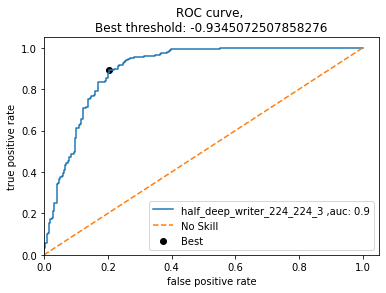

In [45]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_128")

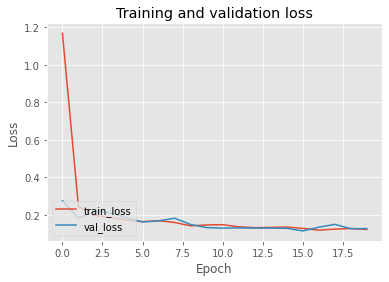

In [48]:
plot_triplet_training(history_siamese_224_224_3_128)

In [70]:
siamese_224_224_3_128.save('saved_models/half_deep_writer_224_224_3_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_128/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_128/assets


## Patches 224x224x3, Embedding Size = 256

In [49]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [50]:
input_shape = (height,width,3)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [51]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [52]:
siamese_224_224_3_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [53]:
siamese_224_224_3_256 = SiameseModel(siamese_224_224_3_256)
siamese_224_224_3_256.compile(optimizer="Adam")
history_siamese_224_224_3_256 = siamese_224_224_3_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 476ms/step - loss: 3.5329 - val_loss: 0.2939
Epoch 2/20
56/56 [==============================] - 27s 474ms/step - loss: 0.2599 - val_loss: 0.1914
Epoch 3/20
56/56 [==============================] - 27s 475ms/step - loss: 0.2086 - val_loss: 0.2092
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.2088 - val_loss: 0.2163
Epoch 5/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1985 - val_loss: 0.1902
Epoch 6/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1799 - val_loss: 0.1690
Epoch 7/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1700 - val_loss: 0.1533
Epoch 8/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1565 - val_loss: 0.1435
Epoch 9/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1606 - val_loss: 0.1384
Epoch 10/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1559 - val_lo

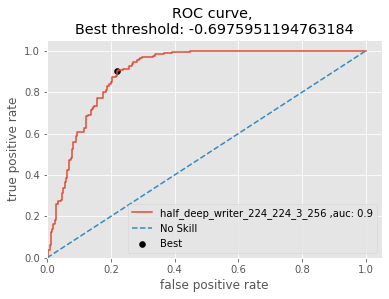

In [54]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_256")

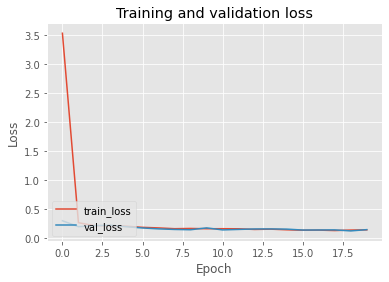

In [55]:
plot_triplet_training(history_siamese_224_224_3_256)

In [71]:
siamese_224_224_3_256.save('saved_models/half_deep_writer_224_224_3_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_256/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_256/assets


## Patches 224x224x3, Embedding Size = 512

In [80]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [81]:
input_shape = (height,width,3)
emb_size = 512
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [82]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [83]:
siamese_224_224_3_512 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [84]:
siamese_224_224_3_512 = SiameseModel(siamese_224_224_3_512)
siamese_224_224_3_512.compile(optimizer="Adam")
history_siamese_224_224_3_512 = siamese_224_224_3_512.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 479ms/step - loss: 5.4647 - val_loss: 0.3040
Epoch 2/20
56/56 [==============================] - 27s 479ms/step - loss: 0.2937 - val_loss: 0.2537
Epoch 3/20
56/56 [==============================] - 27s 478ms/step - loss: 0.2589 - val_loss: 0.2133
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.2059 - val_loss: 0.1729
Epoch 5/20
56/56 [==============================] - 27s 479ms/step - loss: 0.1823 - val_loss: 0.1692
Epoch 6/20
56/56 [==============================] - 27s 479ms/step - loss: 0.1886 - val_loss: 0.1552
Epoch 7/20
56/56 [==============================] - 27s 478ms/step - loss: 0.1698 - val_loss: 0.1384
Epoch 8/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1547 - val_loss: 0.1402
Epoch 9/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1533 - val_loss: 0.1639
Epoch 10/20
56/56 [==============================] - 27s 478ms/step - loss: 0.1571 - val_lo

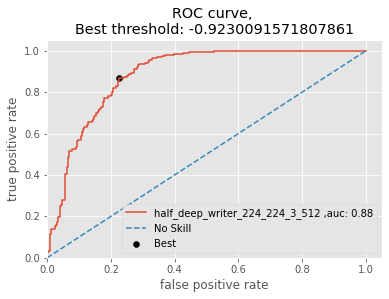

In [85]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_512, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_512")

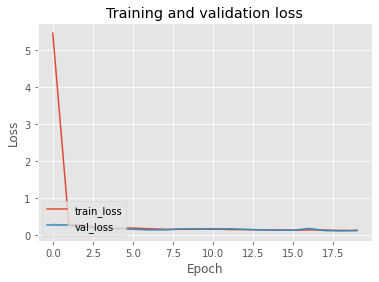

In [86]:
plot_triplet_training(history_siamese_224_224_3_512)

In [87]:
siamese_224_224_3_512.save('saved_models/half_deep_writer_224_224_3_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_512/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_512/assets


## Patches 224x224, Embedding Size = 128

In [95]:
anchor_images_path = "npz_datasets/pairs_20k_224_224_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224_gray/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [96]:
input_shape = (height,width, 1)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [97]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [98]:
siamese_224_224_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [99]:
siamese_224_224_128 = SiameseModel(siamese_224_224_128)
siamese_224_224_128.compile(optimizer="Adam")
history_siamese_224_224_128 = siamese_224_224_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 34s 590ms/step - loss: 0.5841 - val_loss: 0.3141
Epoch 2/20
56/56 [==============================] - 22s 387ms/step - loss: 0.3035 - val_loss: 0.3174
Epoch 3/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2976 - val_loss: 0.2950
Epoch 4/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2957 - val_loss: 0.2930
Epoch 5/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2705 - val_loss: 0.2906
Epoch 6/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2567 - val_loss: 0.2776
Epoch 7/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2657 - val_loss: 0.2750
Epoch 8/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2620 - val_loss: 0.2626
Epoch 9/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2487 - val_loss: 0.2590
Epoch 10/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2544 - val_lo

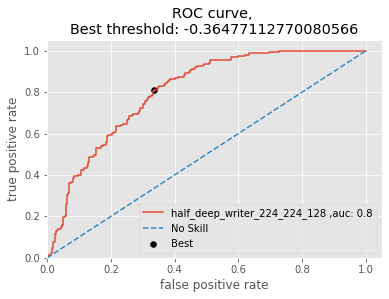

In [100]:
plot_triplet_roc_curve_new(model=siamese_224_224_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_128")

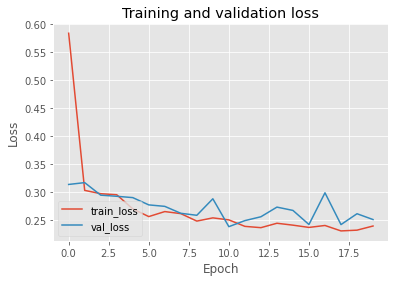

In [101]:
plot_triplet_training(history_siamese_224_224_128)

In [102]:
siamese_224_224_128.save('saved_models/half_deep_writer_224_224_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


## Patches 224x224, Embedding Size = 256

In [103]:
anchor_images_path = "npz_datasets/pairs_20k_224_224_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224_gray/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [104]:
input_shape = (height,width, 1)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [105]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [106]:
siamese_224_224_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [107]:
siamese_224_224_256 = SiameseModel(siamese_224_224_256)
siamese_224_224_256.compile(optimizer="Adam")
history_siamese_224_224_256 = siamese_224_224_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 22s 389ms/step - loss: 0.6829 - val_loss: 0.3396
Epoch 2/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3302 - val_loss: 0.3105
Epoch 3/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3060 - val_loss: 0.3099
Epoch 4/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3051 - val_loss: 0.3017
Epoch 5/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2983 - val_loss: 0.2858
Epoch 6/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2602 - val_loss: 0.2545
Epoch 7/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2633 - val_loss: 0.2894
Epoch 8/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2624 - val_loss: 0.2590
Epoch 9/20
56/56 [==============================] - 22s 387ms/step - loss: 0.2530 - val_loss: 0.2689
Epoch 10/20
56/56 [==============================] - 22s 386ms/step - loss: 0.2494 - val_lo

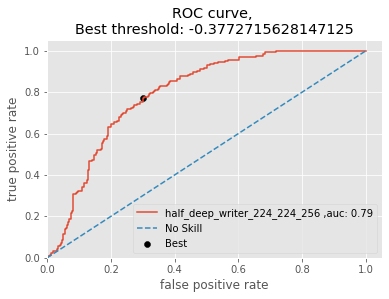

In [108]:
plot_triplet_roc_curve_new(model=siamese_224_224_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_256")

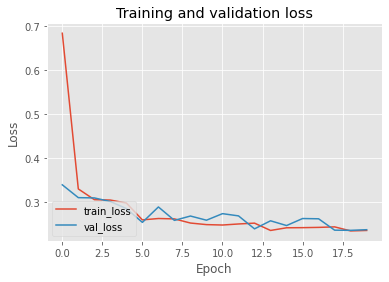

In [109]:
plot_triplet_training(history_siamese_224_224_256)

In [110]:
siamese_224_224_256.save('saved_models/half_deep_writer_224_224_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


## Patches 224x224, Embedding Size = 512

In [3]:
anchor_images_path = "npz_datasets/pairs_20k_224_224_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224_gray/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [8]:
input_shape = (height,width, 1)
emb_size = 512
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [9]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [10]:
siamese_224_224_512 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [11]:
siamese_224_224_512 = SiameseModel(siamese_224_224_512)
siamese_224_224_512.compile(optimizer="Adam")
history_siamese_224_224_512 = siamese_224_224_512.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 43s 590ms/step - loss: 2.5151 - val_loss: 0.3225
Epoch 2/20
56/56 [==============================] - 22s 386ms/step - loss: 0.3007 - val_loss: 0.2792
Epoch 3/20
56/56 [==============================] - 22s 387ms/step - loss: 0.2699 - val_loss: 0.3104
Epoch 4/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2695 - val_loss: 0.2511
Epoch 5/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2694 - val_loss: 0.2641
Epoch 6/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2495 - val_loss: 0.2506
Epoch 7/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2564 - val_loss: 0.2606
Epoch 8/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2545 - val_loss: 0.2500
Epoch 9/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2532 - val_loss: 0.2555
Epoch 10/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2379 - val_lo

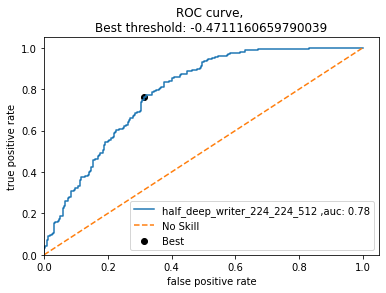

In [12]:
plot_triplet_roc_curve_new(model=siamese_224_224_512, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_512")

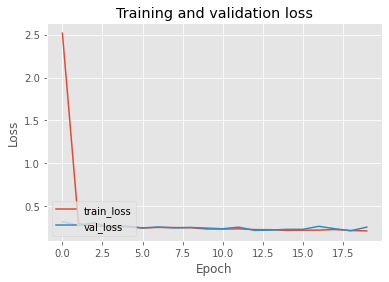

In [13]:
plot_triplet_training(history_siamese_224_224_512)

In [14]:
siamese_224_224_512.save('saved_models/half_deep_writer_224_224_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_512/assets


## Patches 113x113x3, Embedding Size = 128

In [34]:
anchor_images_path = "npz_datasets/pairs_20k_113_113/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [35]:
input_shape = (height,width, 3)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [36]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [37]:
siamese_113_113_3_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [38]:
siamese_113_113_3_128 = SiameseModel(siamese_113_113_3_128)
siamese_113_113_3_128.compile(optimizer="Adam")
history_siamese_113_113_3_128 = siamese_113_113_3_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
59/59 [==============================] - 12s 158ms/step - loss: 0.4375 - val_loss: 0.3784
Epoch 2/20
59/59 [==============================] - 7s 114ms/step - loss: 0.3312 - val_loss: 0.4020
Epoch 3/20
59/59 [==============================] - 7s 116ms/step - loss: 0.3098 - val_loss: 0.2739
Epoch 4/20
59/59 [==============================] - 7s 115ms/step - loss: 0.2773 - val_loss: 0.2569
Epoch 5/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2791 - val_loss: 0.2279
Epoch 6/20
59/59 [==============================] - 7s 115ms/step - loss: 0.2128 - val_loss: 0.2397
Epoch 7/20
59/59 [==============================] - 7s 115ms/step - loss: 0.2153 - val_loss: 0.2159
Epoch 8/20
59/59 [==============================] - 7s 114ms/step - loss: 0.1950 - val_loss: 0.1699
Epoch 9/20
59/59 [==============================] - 7s 115ms/step - loss: 0.1726 - val_loss: 0.1687
Epoch 10/20
59/59 [==============================] - 7s 116ms/step - loss: 0.1644 - val_loss: 0.177

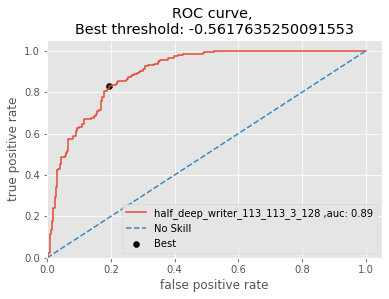

In [39]:
plot_triplet_roc_curve_new(model=siamese_113_113_3_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_3_128")

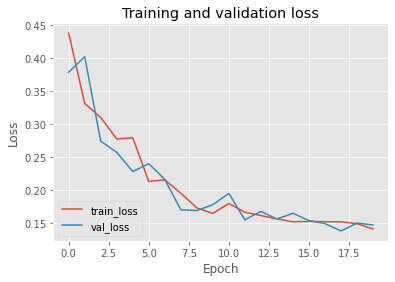

In [40]:
plot_triplet_training(history_siamese_113_113_3_128)

In [41]:
siamese_113_113_3_128.save('saved_models/half_deep_writer_113_113_3_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_128/assets


## Patches 113x113x3, Embedding Size = 256

In [42]:
anchor_images_path = "npz_datasets/pairs_20k_113_113/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [43]:
input_shape = (height,width, 3)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [44]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [45]:
siamese_113_113_3_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [46]:
siamese_113_113_3_256 = SiameseModel(siamese_113_113_3_256)
siamese_113_113_3_256.compile(optimizer="Adam")
history_siamese_113_113_3_256 = siamese_113_113_3_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
59/59 [==============================] - 7s 117ms/step - loss: 0.4211 - val_loss: 0.3286
Epoch 2/20
59/59 [==============================] - 7s 116ms/step - loss: 0.3185 - val_loss: 0.2688
Epoch 3/20
59/59 [==============================] - 7s 114ms/step - loss: 0.2858 - val_loss: 0.2567
Epoch 4/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2788 - val_loss: 0.3847
Epoch 5/20
59/59 [==============================] - 7s 114ms/step - loss: 0.2695 - val_loss: 0.2222
Epoch 6/20
59/59 [==============================] - 7s 117ms/step - loss: 0.2474 - val_loss: 0.2389
Epoch 7/20
59/59 [==============================] - 7s 117ms/step - loss: 0.2091 - val_loss: 0.2105
Epoch 8/20
59/59 [==============================] - 7s 113ms/step - loss: 0.2251 - val_loss: 0.1994
Epoch 9/20
59/59 [==============================] - 7s 115ms/step - loss: 0.1797 - val_loss: 0.1633
Epoch 10/20
59/59 [==============================] - 7s 116ms/step - loss: 0.1699 - val_loss: 0.1744

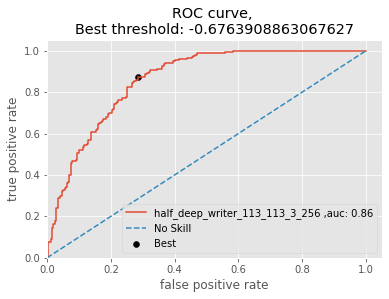

In [47]:
plot_triplet_roc_curve_new(model=siamese_113_113_3_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_3_256")

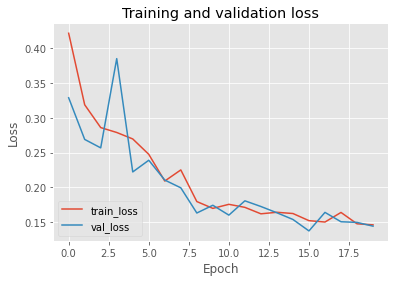

In [48]:
plot_triplet_training(history_siamese_113_113_3_256)

In [49]:
siamese_113_113_3_256.save('saved_models/half_deep_writer_113_113_3_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_256/assets


## Patches 113x113x3, Embedding Size = 512

In [50]:
anchor_images_path = "npz_datasets/pairs_20k_113_113/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [51]:
input_shape = (height,width, 3)
emb_size = 512
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [52]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [53]:
siamese_113_113_3_512 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [54]:
siamese_113_113_3_512 = SiameseModel(siamese_113_113_3_512)
siamese_113_113_3_512.compile(optimizer="Adam")
history_siamese_113_113_3_512 = siamese_113_113_3_512.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
59/59 [==============================] - 7s 116ms/step - loss: 0.5300 - val_loss: 0.3392
Epoch 2/20
59/59 [==============================] - 7s 116ms/step - loss: 0.3352 - val_loss: 0.3153
Epoch 3/20
59/59 [==============================] - 7s 113ms/step - loss: 0.3009 - val_loss: 0.3931
Epoch 4/20
59/59 [==============================] - 7s 115ms/step - loss: 0.2893 - val_loss: 0.2615
Epoch 5/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2535 - val_loss: 0.2398
Epoch 6/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2325 - val_loss: 0.2502
Epoch 7/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2276 - val_loss: 0.2379
Epoch 8/20
59/59 [==============================] - 7s 116ms/step - loss: 0.2197 - val_loss: 0.2288
Epoch 9/20
59/59 [==============================] - 7s 114ms/step - loss: 0.2219 - val_loss: 0.2451
Epoch 10/20
59/59 [==============================] - 7s 117ms/step - loss: 0.2398 - val_loss: 0.2005

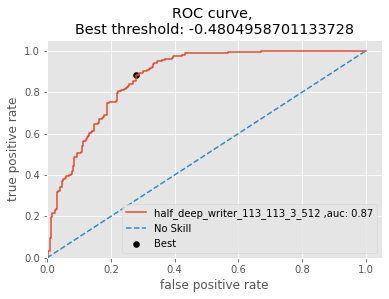

In [55]:
plot_triplet_roc_curve_new(model=siamese_113_113_3_512, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_3_512")

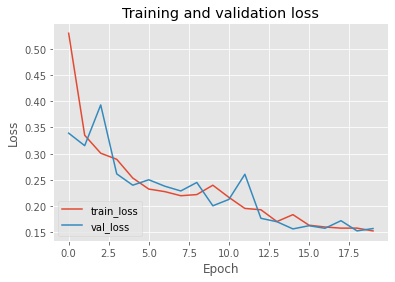

In [56]:
plot_triplet_training(history_siamese_113_113_3_512)

In [57]:
siamese_113_113_3_512.save('saved_models/half_deep_writer_113_113_3_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_512/assets


## Patches 113x113, Embedding Size = 128

In [58]:
anchor_images_path = "npz_datasets/pairs_20k_113_113_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113_gray/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [59]:
input_shape = (height,width, 1)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [60]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [61]:
siamese_113_113_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [62]:
siamese_113_113_128 = SiameseModel(siamese_113_113_128)
siamese_113_113_128.compile(optimizer="Adam")
history_siamese_113_113_128 = siamese_113_113_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 9s 145ms/step - loss: 0.3862 - val_loss: 0.3739
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 0.3379 - val_loss: 0.3567
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 0.3135 - val_loss: 0.3274
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2936 - val_loss: 0.2845
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2789 - val_loss: 0.2795
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2651 - val_loss: 0.2998
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2671 - val_loss: 0.2613
Epoch 8/20
56/56 [==============================] - 6s 98ms/step - loss: 0.2613 - val_loss: 0.2964
Epoch 9/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2579 - val_loss: 0.2490
Epoch 10/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2486 - val_loss: 0.2357
Epoch 11

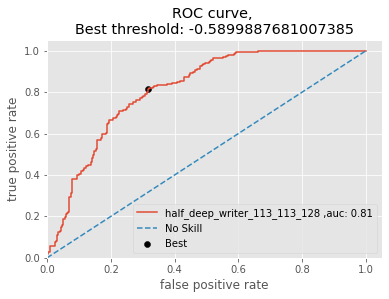

In [63]:
plot_triplet_roc_curve_new(model=siamese_113_113_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_128")

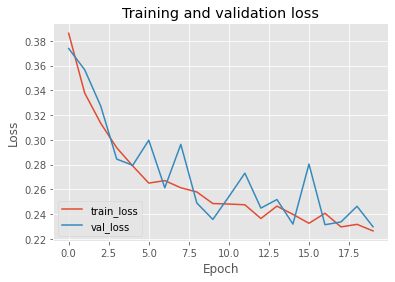

In [64]:
plot_triplet_training(history_siamese_113_113_128)

In [82]:
siamese_113_113_128.save('saved_models/half_deep_writer_113_113_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_128/assets


## Patches 113x113, Embedding Size = 256

In [66]:
anchor_images_path = "npz_datasets/pairs_20k_113_113_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113_gray/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [67]:
input_shape = (height,width, 1)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [68]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [69]:
siamese_113_113_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [70]:
siamese_113_113_256 = SiameseModel(siamese_113_113_256)
siamese_113_113_256.compile(optimizer="Adam")
history_siamese_113_113_256 = siamese_113_113_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 6s 99ms/step - loss: 0.4253 - val_loss: 0.3456
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 0.3359 - val_loss: 0.3582
Epoch 3/20
56/56 [==============================] - 5s 98ms/step - loss: 0.3251 - val_loss: 0.3107
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 0.3083 - val_loss: 0.3280
Epoch 5/20
56/56 [==============================] - 5s 98ms/step - loss: 0.3101 - val_loss: 0.3166
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 0.3097 - val_loss: 0.3008
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2862 - val_loss: 0.2671
Epoch 8/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2644 - val_loss: 0.2532
Epoch 9/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2630 - val_loss: 0.2723
Epoch 10/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2623 - val_loss: 0.2722
Epoch 11/

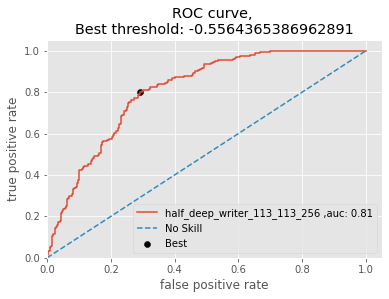

In [71]:
plot_triplet_roc_curve_new(model=siamese_113_113_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_256")

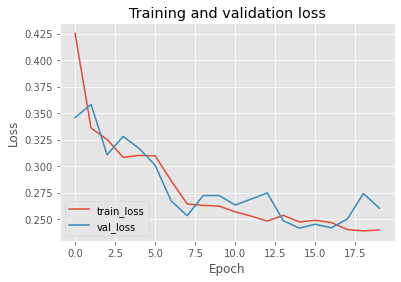

In [72]:
plot_triplet_training(history_siamese_113_113_256)

In [83]:
siamese_113_113_256.save('saved_models/half_deep_writer_113_113_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_256/assets


## Patches 113x113, Embedding Size = 512

In [43]:
anchor_images_path = "npz_datasets/pairs_20k_113_113_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113_gray/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [75]:
input_shape = (height,width, 1)
emb_size = 512
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [76]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [77]:
siamese_113_113_512 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [79]:
siamese_113_113_512 = SiameseModel(siamese_113_113_512)
siamese_113_113_512.compile(optimizer="Adam")
history_siamese_113_113_512 = siamese_113_113_512.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 6s 99ms/step - loss: 0.2346 - val_loss: 0.2531
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2295 - val_loss: 0.2272
Epoch 3/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2224 - val_loss: 0.2307
Epoch 4/20
56/56 [==============================] - 6s 98ms/step - loss: 0.2204 - val_loss: 0.2207
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2214 - val_loss: 0.2350
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2162 - val_loss: 0.2251
Epoch 7/20
56/56 [==============================] - 5s 97ms/step - loss: 0.2143 - val_loss: 0.2255
Epoch 8/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2180 - val_loss: 0.2270
Epoch 9/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2218 - val_loss: 0.2288
Epoch 10/20
56/56 [==============================] - 5s 98ms/step - loss: 0.2185 - val_loss: 0.2345
Epoch 11/

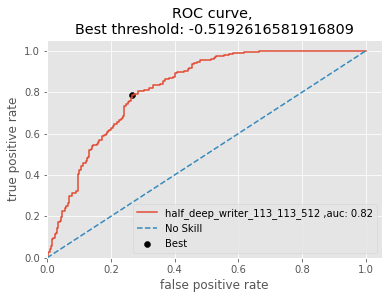

In [80]:
plot_triplet_roc_curve_new(model=siamese_113_113_512, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_113_113_512")

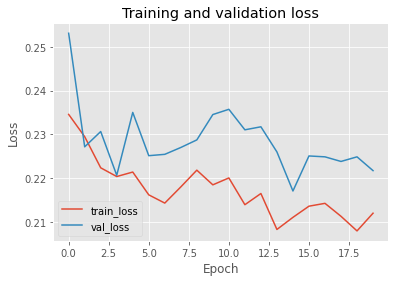

In [81]:
plot_triplet_training(history_siamese_113_113_512)

In [84]:
siamese_113_113_512.save('saved_models/half_deep_writer_113_113_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_512/assets


# Contrastive Loss

In [3]:
import os
import numpy as np
import random

In [4]:
def preprocess_image_pair(filename, target_shape=(224,224)):
    """
    Function for loading the images, preprocess is and reshape it to target shape
    
    Argumemnts:
        filename: filepath in string_format
    
    Returns:
        Preprocessed image
    """

    image_string = tf.io.read_file(filename)

    image = tf.image.decode_jpeg(image_string, channels=3)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image



def preprocess_pa(x, y):
    """
    Function for loading and preprocessing image pairs
    
    Arguments:
        anchor: path to anchor image
        positive: path to positive image
        anchor: path to negative image
        
    Returns:
        Preprocessed image triplets
    """
    anchor = x[0]
    positive_negative = x[1]

    return (
        (((preprocess_image_pair(anchor), preprocess_image_pair(positive_negative)), y))
    )



In [5]:
def preprocess_pairs(anchor, positive_negative):
    """
    Function for loading and preprocessing image pairs
    
    Arguments:
        anchor: path to anchor image
        positive: path to positive image
        anchor: path to negative image
        
    Returns:
        Preprocessed image triplets
    """

    return (
        preprocess_image_pair(anchor),
        preprocess_image_pair(positive_negative)
    )



In [6]:
def create_tf_data_datasets_contrastive(anchor_images_path, positive_images_path, height, width, batch_size):
    """
    Function for creating tf data datasets input pipeline for triplet loss. The target shape must be changed in the "preprocess_image()" function!
    
    Arguments:
        anchor_images_path: path to anchor dir in string_format
        positive_images_path: path to positive dir in string_format
        height: target height of image
        width: target width of image
        batch_size: desired batch size for training
        
    Returns:
        train and val datasets
    """
    
    #list and sort the data in folders
    anchor_images = sorted([str(anchor_images_path + "/" + f) for f in os.listdir(anchor_images_path)])
    positive_images = sorted([str(positive_images_path + "/" + f) for f in os.listdir(positive_images_path)])
    image_count = len(anchor_images)
    
    #select 50% of anchor and positive dataset
    random_anchor_positive = random.sample(range(0, image_count), (round(image_count * 0.5)))
    anchor_1 = [anchor_images[i] for i in random_anchor_positive]
    positive = [positive_images[i] for i in random_anchor_positive]
    y_same = np.ones([(len(anchor_1)), 1])
    
    #select 50% of anchor and positive dataset - but for negative image pairs
    #check randomness with while loop 
    i = 0
    while i < 1:
        #shuffle two image lists
        random.shuffle(anchor_images)
        random.shuffle(positive_images)

        random_anchor_negative_1 = random.sample(range(0, image_count), (round(image_count * 0.5)))
        random_anchor_negative_2 = random.sample(range(0, image_count), (round(image_count * 0.5)))

        anchor_2 = [anchor_images[i] for i in random_anchor_negative_1]
        negative = [positive_images[i] for i in random_anchor_negative_2]

        #check if there are no same image pairs in dataset
        if (set(anchor_2) == set(negative)) == True:
            pass
        else:
            i += 1

    y_different = np.zeros([(len(anchor_2)), 1])
    
    #concatenatoe the lists
    anchor_images = anchor_1 + anchor_2
    positive_negative_images = positive + negative
    y = np.append(y_same, y_different)
    y = np.expand_dims(y, axis=1)
    #y = list(y)
    
    """
    #create tf data datasets
    anchor = tf.data.Dataset.from_tensor_slices(anchor_images)
    pos_neg = tf.data.Dataset.from_tensor_slices(positive_negative_images)
    """
    dataset = tf.data.Dataset.from_tensor_slices((anchor_images, positive_negative_images))
    y = tf.data.Dataset.from_tensor_slices(y)

    """
    #zip the datasets
    dataset = tf.data.Dataset.zip((anchor, pos_neg, y))
    dataset = dataset.shuffle(buffer_size=(image_count))
    dataset.map(preprocess_pairs)
    dataset = dataset.shuffle(buffer_size=(image_count))
    """
    #dataset = tf.data.Dataset.zip((anchor, pos_neg))
    dataset = dataset.map(preprocess_pairs)
    dataset = tf.data.Dataset.zip((dataset, y))
    dataset = dataset.shuffle(buffer_size=(image_count))
    
    
    #split the dataset
    train_dataset = dataset.take(round(image_count * 0.8))
    train_dataset = train_dataset.shuffle(buffer_size=(image_count))
    val_dataset = dataset.skip(round(image_count * 0.8))
    val_dataset = val_dataset.shuffle(buffer_size=(image_count))

    train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset

In [7]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [8]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3)), (None, 1)), types: ((tf.float32, tf.float32), tf.float64)>

In [21]:
def contrastive_loss(y_true, y_pred, margin=1):
    """
    Calculates the contrastive loss
    
    Arguments:
        y_true: List of labels
        y_pred: List of predicted labels with same length as y
        margin: Intergervalue, defines the baseline distance for which pairs should be classified as dissimilar
    
    Returns:
        A tensor containing constrastive loss
    """
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean( (1 - y_true) * square_pred + (y_true) * margin_square)

In [22]:
def euclidean_distance(vectors):
    """
    Calculates the euclidian distance between two vectors
    
    Arguments:
        vectors: List containing two tensors of same length
    
    Return:
        Tensor containing euclidian distance between vectors
    """
    x, y = vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [23]:
input_shape = (height,width,3)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [24]:
anchor_input = keras.layers.Input(shape=input_shape)
pos_neg_input = keras.layers.Input(shape=input_shape)

feat_vect_a = embedding_half_deep_writer(anchor_input)
feat_vect_b = embedding_half_deep_writer(pos_neg_input)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
normal = keras.layers.BatchNormalization()(distance)
outputs = keras.layers.Dense(1, activation="sigmoid")(normal)


In [25]:
siamese_test = keras.models.Model(inputs=[anchor_input,pos_neg_input],
                                  outputs=outputs)

In [26]:
siamese_test.compile(loss=contrastive_loss, optimizer="Adam", metrics="accuracy")

In [27]:
siamese_test.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
56/56 [==============================] - 20s 321ms/step - loss: 0.2496 - accuracy: 0.5251 - val_loss: 0.2498 - val_accuracy: 0.4905
Epoch 2/10
56/56 [==============================] - 20s 321ms/step - loss: 0.2435 - accuracy: 0.6248 - val_loss: 0.2229 - val_accuracy: 0.6283
Epoch 3/10
56/56 [==============================] - 19s 319ms/step - loss: 0.2331 - accuracy: 0.6735 - val_loss: 0.2115 - val_accuracy: 0.6819
Epoch 4/10
56/56 [==============================] - 19s 318ms/step - loss: 0.2246 - accuracy: 0.6863 - val_loss: 0.2128 - val_accuracy: 0.6364
Epoch 5/10
56/56 [==============================] - 19s 316ms/step - loss: 0.2175 - accuracy: 0.6896 - val_loss: 0.1997 - val_accuracy: 0.7082
Epoch 6/10
56/56 [==============================] - 19s 317ms/step - loss: 0.2132 - accuracy: 0.6896 - val_loss: 0.2085 - val_accuracy: 0.7146
Epoch 7/10
56/56 [==============================] - 19s 318ms/step - loss: 0.2052 - accuracy: 0.7053 - val_loss: 0.1934 - val_accuracy: 0.7127